<a href="https://colab.research.google.com/github/laloflogar/RB2026/blob/main/Gr%C3%A1ficas_nacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gráfica 1: Producto Interno Bruto

In [ ]:
import numpy as np
import pandas as pd
import requests
from datetime import datetime
import plotly.graph_objects as go

Llamar a la API


In [ ]:
def descarga_bmx_series(series_dict, fechainicio, fechafin):
    # Token de acceso a la API de Banxico
    token = '26153e6c82692ded865088de00a0a217d9badd95674380b26b618a597e1285db'
    headers = {'Bmx-Token': token}
    all_data = []  # Lista para almacenar los DataFrames de cada serie

    # Itera sobre el diccionario de series proporcionado
    for serie, nombre in series_dict.items():
        # Construye la URL para la consulta API usando la serie y las fechas
        url = f'https://www.banxico.org.mx/SieAPIRest/service/v1/series/{serie}/datos/{fechainicio}/{fechafin}/'
        response = requests.get(url, headers=headers)  # Realiza la petición HTTP

        # Verifica si la respuesta es exitosa
        if response.status_code != 200:
            print(f'Error en la consulta para la serie {nombre}, código {response.status_code}')
            continue

        raw_data = response.json()  # Obtiene los datos en formato JSON

        # Verifica la estructura del JSON y si contiene datos
        if 'bmx' in raw_data and 'series' in raw_data['bmx'] and len(raw_data['bmx']['series']) > 0:
            serie_data = raw_data['bmx']['series'][0]

            if 'datos' in serie_data and len(serie_data['datos']) > 0:
                data = serie_data['datos']
                df = pd.DataFrame(data)
                # Elimina las comas antes de convertir a float
                df['dato'] = df['dato'].str.replace(',', '', regex=False).replace('N/E', np.nan).astype(float)  # Convierte los datos a float y maneja los no disponibles
                df['fecha'] = pd.to_datetime(df['fecha'], dayfirst=True)  # Convierte la columna de fecha al formato datetime
                df.set_index('fecha', inplace=True)  # Establece la columna de fecha como índice del DataFrame
                df.rename(columns={'dato': nombre}, inplace=True)  # Renombra la columna de datos con el nombre de la serie
                all_data.append(df)  # Agrega el DataFrame a la lista all_data
            else:
                print(f"No se encontraron datos para la serie {nombre}")
        else:
            print(f"Estructura inesperada en la respuesta para la serie {nombre}")

    # Concatena todos los DataFrames en uno solo si se descargaron datos
    if all_data:
        df_final = pd.concat(all_data, axis=1)
        return df_final
    else:
        print("No se descargaron datos.")
        return None

Crear el Dataframe

In [ ]:
# Define las series de datos y sus códigos correspondientes
series = {
    'SR17622': 'PIB Trimestral, a.e.'
}

# Define el rango de fechas de interés
fechainicio = '2010-01-01'
fechafin = pd.Timestamp.today().strftime('%Y-%m-%d')

# Llama a la función y asigna el resultado a df_final
df_final = descarga_bmx_series(series, fechainicio, fechafin)

# Verifica si se descargaron datos y muestra los primeros registros
if df_final is not None:
    print("Datos descargados exitosamente ✅ :")
    print(df_final.tail())  # Muestra los últimos registros para confirmar la descarga
else:
    print("No se pudo descargar ningún dato.")

Datos descargados exitosamente ✅ :
            PIB Trimestral, a.e.
fecha                           
2024-07-01            25464799.5
2024-10-01            25317392.2
2025-01-01            25375315.1
2025-04-01            25488536.9
2025-07-01            25415333.0


Calcular la variación trimestral

In [ ]:
# Filtrar el DataFrame desde 2018-01-01
df_filtered = df_final[df_final.index >= '2018-01-01'].copy()

# Obtener el valor del PIB para 2019-IV (cuarto trimestre de 2019, que inicia en 2019-10-01)
pib_2019_q4_value = df_filtered.loc['2019-10-01', 'PIB Trimestral, a.e.']

# Calcular el PIB como índice base 2019-IV=100
df_filtered['PIB_Base_2019_IV_100'] = (df_filtered['PIB Trimestral, a.e.'] / pib_2019_q4_value) * 100

# Calcular la variación respecto al trimestre anterior
df_filtered['Variacion_Trimestral'] = df_filtered['PIB Trimestral, a.e.'].pct_change() * 100

# Crear el nuevo DataFrame con las columnas solicitadas
df_pib_analisis = df_filtered[['PIB_Base_2019_IV_100', 'Variacion_Trimestral']]

print("DataFrame de análisis de PIB creado exitosamente ✅ :")
display(df_pib_analisis.head())
display(df_pib_analisis.tail())

DataFrame de análisis de PIB creado exitosamente ✅ :


,PIB_Base_2019_IV_100,Variacion_Trimestral
fecha,,
2018-01-01,101.087737,NaN
2018-04-01,100.777623,-0.306777
2018-07-01,101.190693,0.409883
2018-10-01,100.999888,-0.188560
2019-01-01,101.012675,0.012660


,PIB_Base_2019_IV_100,Variacion_Trimestral
fecha,,
2024-07-01,106.337029,0.909260
2024-10-01,105.721480,-0.578867
2025-01-01,105.963357,0.228787
2025-04-01,106.436153,0.446189
2025-07-01,106.130465,-0.287203


Graficar

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

# Create a figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add 'Variacion_Trimestral' as a bar chart (blue) on the primary y-axis
fig.add_trace(
    go.Bar(
        x=df_pib_analisis.index,
        y=df_pib_analisis['Variacion_Trimestral'],
        name='Variación Trimestral',
        marker_color='blue',
        yaxis='y1'
    )
)

# Add 'PIB_Base_2019_IV_100' as a line chart (red) on the secondary y-axis
fig.add_trace(
    go.Scatter(
        x=df_pib_analisis.index,
        y=df_pib_analisis['PIB_Base_2019_IV_100'],
        mode='lines',
        name='PIB Base 2019-IV=100',
        line=dict(color='red'),
        yaxis='y2'
    )
)

# Get min and max dates for vertical lines
min_date = df_pib_analisis.index.min()
max_date = df_pib_analisis.index.max()


# Update layout for dual Y-axes, title, subtitle, footnote, arrows, and axis ranges
fig.update_layout(
    title_text='<b>Gráfica 00: Producto Interno Bruto</b>', # Bold and centered title
    title_x=0.5,
    hovermode='x unified',
    plot_bgcolor='white', # White background
    width=700,
    height=500,
    # Define y-axes directly in layout
    xaxis=dict(
        showgrid=False,
        gridwidth=1,
        gridcolor='LightGrey',
        showline=True,
        linewidth=1,
        linecolor='black',
        mirror=False
    ),
    yaxis=dict(
        title_text=' ',
        range=[-6, 4], # Primary Y-axis range
        showline=True,
        linewidth=1,
        linecolor='blue',
        mirror=True,
        zeroline=True,
        zerolinecolor='lightgray',
        zerolinewidth=1,
        showgrid=False,
        gridwidth=1,
        gridcolor='LightGrey',
        title_font=dict(color="black"),
        tickfont=dict(color="black")
    ),
    yaxis2=dict(
        title_text=' ',
        range=[88, 108], # Secondary Y-axis range
        showline=True,
        linewidth=2,
        linecolor='gray',
        mirror=True,
        overlaying='y',
        side='right',
        zeroline=True,
        zerolinecolor='lightgray',
        zerolinewidth=1,
        showgrid=False,
        gridwidth=1,
        gridcolor='LightGrey',
        title_font=dict(color="black"),
        tickfont=dict(color="black")
    ),
    annotations=[
        # Subtitle
        dict(
            xref="paper", yref="paper",
            x=0.5, y=1.05,  # Position above the main title
            xanchor="center", yanchor="bottom",
            text="Variaciones trimestrales en por ciento e índice 2019-IV=100, a.e.",
            font=dict(size=14),
            showarrow=False
        ),
        # Footnote
        dict(
            xref="paper", yref="paper",
            x=0, y=-0.15, # Position below the x-axis
            xanchor="left", yanchor="top",
            text="Fuente: Elaboración propia con datos de Banxico.<br>*Se acotó la escala vertical para facilitar su lectura.",
            font=dict(size=10),
            showarrow=False
        ),
        # Red arrow
        dict(
            xref="paper", yref="paper",
            x=0.7, y=0.95, # Top-left corner of the plotting area
            text="",
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="red",
            ax=-60, ay=0, # Tail is 30 pixels left, 0 vertical offset from head
            xanchor="right", yanchor="bottom"
        ),
        #Blue arrow
        dict(
            xref="paper", yref="paper",
            x=0.8, y=0.75, # Top-right corner of the plotting area
            text="",
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="blue",
            ax=60, ay=0, # Tail is 30 pixels right, 0 vertical offset from head
            xanchor="left", yanchor="bottom"
        ),
        #Lines
        dict(
            xref="paper", yref="paper",
            x=0.265, y=0,
            text="",
            showarrow=True,
            arrowhead=0,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="black",
            ax=30, ay=-5,
            xanchor="left", yanchor="bottom"
        ),
        dict(
            xref="paper", yref="paper",
            x=0.265, y=0.015,
            text="",
            showarrow=True,
            arrowhead=0,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="black",
            ax=30, ay=-5,
            xanchor="left", yanchor="bottom"
        ),
        dict(
            xref="paper", yref="paper",
            x=0.3, y=0.98,
            text="",
            showarrow=True,
            arrowhead=0,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="black",
            ax=38, ay=-5,
            xanchor="left", yanchor="bottom"
        ),
        dict(
            xref="paper", yref="paper",
            x=0.3, y=0.96,
            text="",
            showarrow=True,
            arrowhead=0,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="black",
            ax=38, ay=-5,
            xanchor="left", yanchor="bottom"
        ),

        # Data labels for 2020-Q2, Q3, Q4
        dict(
            x='2019-11-01', y=-5.9,
            text=f"{df_pib_analisis.loc['2020-04-01', 'Variacion_Trimestral']:.2f}",
            showarrow=False, yshift=10, font=dict(color="blue", size=10)
        ),
        dict(
            x='2020-02-01', y=3.65,
            text=f"{df_pib_analisis.loc['2020-07-01', 'Variacion_Trimestral']:.2f}",
            showarrow=False, yshift=10, font=dict(color="blue", size=10)
        ),
        dict(
            x='2021-03-01', y=3.65,
            text=f"{df_pib_analisis.loc['2020-10-01', 'Variacion_Trimestral']:.2f}",
            showarrow=False, yshift=10, font=dict(color="blue", size=10)
        ),
        dict(
            x='2020-11-01', y=-5.9,
            text=f"{df_pib_analisis.loc['2020-04-01', 'PIB_Base_2019_IV_100']:.2f}",
            showarrow=False, yshift=10, font=dict(color="red", size=10)
        )
    ],
    legend=dict(
        x=0.94, # Right side of the plot
        y=0.01, # Bottom of the plot
        xanchor='right', # Anchor the legend to the right
        yanchor='bottom', # Anchor the legend to the bottom
        bgcolor='rgba(255, 255, 255, 0.5)', # Optional: translucent background
        bordercolor='rgba(0, 0, 0, 0)'
    )
)

fig.show()

# Gráfica 2: variaciones anuales en por ciento

Llamado al API

In [120]:
import requests
import json
import pandas as pd

#Llamado al API
token='337db32f-2268-33f9-43e8-c853b84b6ee9'
original='735904' # Serie para PIB Original
desest='736183' # Serie para PIB Desestacionalizado
fecha_inicio='2018-01-01'
url1='https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/'+original+'/es/00/false/BIE-BISE/2.0/'+token+'?type=jsonn'
url2='https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/'+desest+'/es/00/false/BIE-BISE/2.0/'+token+'?type=jsonn'


# VARIACIÓN DEL PIB SERIES ORIGINALES
response = requests.get(url1)
if response.status_code == 200:
    content = json.loads(response.content)
    series_original = content['Series'][0]['OBSERVATIONS']

    # Crear DataFrame para la serie original
    df_original = pd.DataFrame(series_original)
    df_original = df_original.rename(columns={'OBS_VALUE': 'var_PIB_original'})
    df_original['var_PIB_original'] = pd.to_numeric(df_original['var_PIB_original'], errors='coerce')
    df_original = df_original[['TIME_PERIOD', 'var_PIB_original']]
else:
    print(f"Error al obtener datos de la serie original: {response.status_code}")
    df_original = pd.DataFrame()

# VARIACIÓN DEL PIB SERIES DESESTACIONALIZADAS
response = requests.get(url2)
if response.status_code == 200:
    content = json.loads(response.content)
    series_desest = content['Series'][0]['OBSERVATIONS']

    # Crear DataFrame para la serie desestacionalizada
    df_desest = pd.DataFrame(series_desest)
    df_desest = df_desest.rename(columns={'OBS_VALUE': 'var_PIB_desest'})
    df_desest['var_PIB_desest'] = pd.to_numeric(df_desest['var_PIB_desest'], errors='coerce')
    df_desest = df_desest[['TIME_PERIOD', 'var_PIB_desest']]
else:
    print(f"Error al obtener datos de la serie desestacionalizada: {response.status_code}")
    df_desest = pd.DataFrame()

# Fusionar los DataFrames si ambos tienen datos
if not df_original.empty and not df_desest.empty:
    base = pd.merge(df_original, df_desest, on='TIME_PERIOD', how='outer')
elif not df_original.empty:
    base = df_original
elif not df_desest.empty:
    base = df_desest
else:
    base = pd.DataFrame() # Crear un DataFrame vacío si no se pudo descargar ningún dato

# Convert TIME_PERIOD to datetime objects
if not base.empty:
    base['TIME_PERIOD'] = pd.to_datetime(base['TIME_PERIOD'], format='%Y/%m')

# Set TIME_PERIOD as index
base = base.set_index('TIME_PERIOD')

# Filtrar el Dataframe desde la fecha de inicio
base_filtrada = base[base.index >= fecha_inicio].copy()

display(base_filtrada.head())
display(base_filtrada.tail())

,var_PIB_original,var_PIB_desest
TIME_PERIOD,,
2018-01-01,1.125548,2.169519
2018-02-01,2.890753,1.743777
2018-03-01,2.750042,2.768490
2018-04-01,1.136534,1.162598
2019-01-01,0.942800,-0.074254


,var_PIB_original,var_PIB_desest
TIME_PERIOD,,
2024-03-01,1.400972,1.280210
2024-04-01,0.267262,0.368927
2025-01-01,0.558752,0.419863
2025-02-01,-0.068081,1.003324
2025-03-01,-0.119997,-0.194255


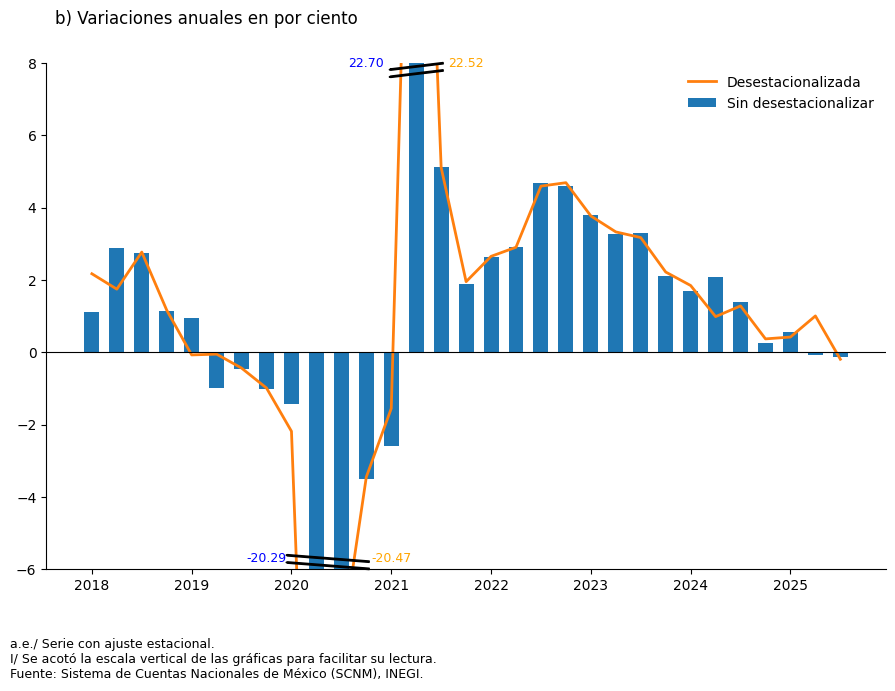

In [212]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Asegurar orden y convertir a PeriodIndex trimestral
df = base_filtrada.copy().sort_index()
df.index = df.index.to_period('Q')

# 2. Crear eje X numérico uniforme
x = np.arange(len(df))

# 3. Figura
fig, ax = plt.subplots(figsize=(9, 7)) # Aumentar el tamaño de la figura

# 4. Barras: sin desestacionalizar
ax.bar(
    x,
    df['var_PIB_original'],
    width=0.6,
    color='#1f77b4',
    label='Sin desestacionalizar'
)

# 5. Línea: desestacionalizada
ax.plot(
    x,
    df['var_PIB_desest'],
    color='#ff7f0e',
    linewidth=2,
    label='Desestacionalizada'
)

# 6. Línea horizontal en cero
ax.axhline(0, color='black', linewidth=0.8)

# 7. Etiquetas del eje X (solo años)
ax.set_xticks(x[::4])
ax.set_xticklabels(df.index.astype(str)[::4].str[:4])

# 8. Límites eje Y
ax.set_ylim(-6, 8)

# 9. Títulos y formato
fig.suptitle('', ha='left', x=0.3, y=0.95, fontsize=16) # Título principal de la figura
ax.set_title('b) Variaciones anuales en por ciento', x=0.01, y=1.05, loc='left', pad=10) # Aumentar el padding del título

ax.legend(frameon=False)

# Estilo limpio
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Lineas de acotación
ax.annotate(
    '',  # Sin texto
    xy=(x[0] + 7.6, -5.8),  # Cabeza de la flecha (punto final)
    xytext=(x[0] + 11.3, -6),  # Cola de la flecha (punto inicial)
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=1, headlength=1)
)
ax.annotate(
    '',  # Sin texto
    xy=(x[0] + 7.6, -5.6),  # Cabeza de la flecha (punto final)
    xytext=(x[0] + 11.3, -5.8),  # Cola de la flecha (punto inicial)
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=1, headlength=1)
)
ax.annotate(
    '',  # Sin texto
    xy=(x[0] + 11.8, +7.8),  # Cabeza de la flecha (punto final)
    xytext=(x[0] + 14.2, +8),  # Cola de la flecha (punto inicial)
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=1, headlength=1)
)
ax.annotate(
    '',  # Sin texto
    xy=(x[0] + 11.8, +7.6),  # Cabeza de la flecha (punto final)
    xytext=(x[0] + 14.2, +7.8),  # Cola de la flecha (punto inicial)
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=1, headlength=1)
)

# Etiquetas de datos mínimos y máximos
# Para 'var_PIB_original' (barras)
min_original_value = df['var_PIB_original'].min()
max_original_value = df['var_PIB_original'].max()
min_original_idx = df['var_PIB_original'].idxmin()
max_original_idx = df['var_PIB_original'].idxmax()

x_coords = {idx: i for i, idx in enumerate(df.index)}

ax.annotate(f'{min_original_value:.2f}',
            xy=(0, 0),
            xytext=(7, -5.7),# Centered vertically
            ha='center', va='center', color='blue', fontsize=9)
ax.annotate(f'{max_original_value:.2f}',
            xy=(0, 0),
            xytext=(11, 8), # Centered vertically
            ha='center', va='center', color='blue', fontsize=9)

# Para 'var_PIB_desest' (línea)
min_desest_value = df['var_PIB_desest'].min()
max_desest_value = df['var_PIB_desest'].max()
min_desest_idx = df['var_PIB_desest'].idxmin()
max_desest_idx = df['var_PIB_desest'].idxmax()

ax.annotate(f'{min_desest_value:.2f}',
            xy=(0, 0),
            xytext=(12, -5.7), # Centered vertically
            ha='center', va='center', color='orange', fontsize=9)
ax.annotate(f'{max_desest_value:.2f}',
            xy=(0, 0),
            xytext=(15, 8), # Centered vertically
            ha='center', va='center', color='orange', fontsize=9)


# Nota al pie
plt.figtext(
    0.01, -0.05, # Ajustar la posición y para dar más espacio
    'a.e./ Serie con ajuste estacional.\n'
    'I/ Se acotó la escala vertical de las gráficas para facilitar su lectura.\n'
    'Fuente: Sistema de Cuentas Nacionales de México (SCNM), INEGI.',
    ha='left',
    fontsize=9
)

plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Ajustar tight_layout para dejar espacio al suptitle y figtext
plt.show()